# B.1 : survival analysis problem, Cox Model, impact of mutational signatures
In this notebook, we compare, for the survival analysis problem with the Cox Model, the following configurations :
- without mutational signatures (only biomarkers from the reference article : https://doi.org/10.1158/1078-0432.CCR-20-1163)
- with only mutational signatures
- with combination of reference article biomarkers and the mutational signatures

## Table of contents

1. [No mutational signatures](#1-no-sigmut)
2. [Only mutational signatures](#2-only-sigmut)
3. [Initial biomarkers + mutational signatures](#3-not-normalized-sigmut)
4. [Evaluate performances](#4-performances)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import torch

from evaluation.SurvivalMetrics import SurvivalMetrics

from manage.CoxTrainTestManager import CoxTrainTestManager

from sklearn.preprocessing import StandardScaler

from utils.featureSelection import featureSelection
from utils.preProcessing import preProcessing

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


#### Set hyper-parameters

In [2]:
n_features = 5

#### Reading and preprocessing

In [3]:
# Reading dataset
df = pd.read_excel('data/cohort-dataset.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = preProcessing.delete_nan_values(df)

# Relabel patients (t = 183 days = 6 months)
t = 183
df = preProcessing.relabel_patients(df, "Progression_1", "Time to progression (days)", t)
df = preProcessing.relabel_patients(df, "Alive_0", "Overall survival (days)", t)

# Normalize initial biomarkers
features_to_normalize = ["Age at advanced disease diagnosis",
                         "CD8+ T cell score",
                         "Genome mut per mb",
                         "Exome mut per mb",
                         "CD274 expression",
                         "M1M2 expression"]

df.loc[:, features_to_normalize] = preProcessing.normalize_data(df.loc[:, features_to_normalize])

# Extract labels
# TTP :
y_cox_ttp = np.array(list((df[['Progression_1', 'Time to progression (days)']].itertuples(index=False, name=None))),
                     dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])

# OS :
y_cox_os = np.array(list((df[['Alive_0', 'Overall survival (days)']].itertuples(index=False, name=None))),
                    dtype=[('Alive_0', '?'), ('Overall survival (days)', '<f8')])

### 1. No mutational signatures

#### Feature selection

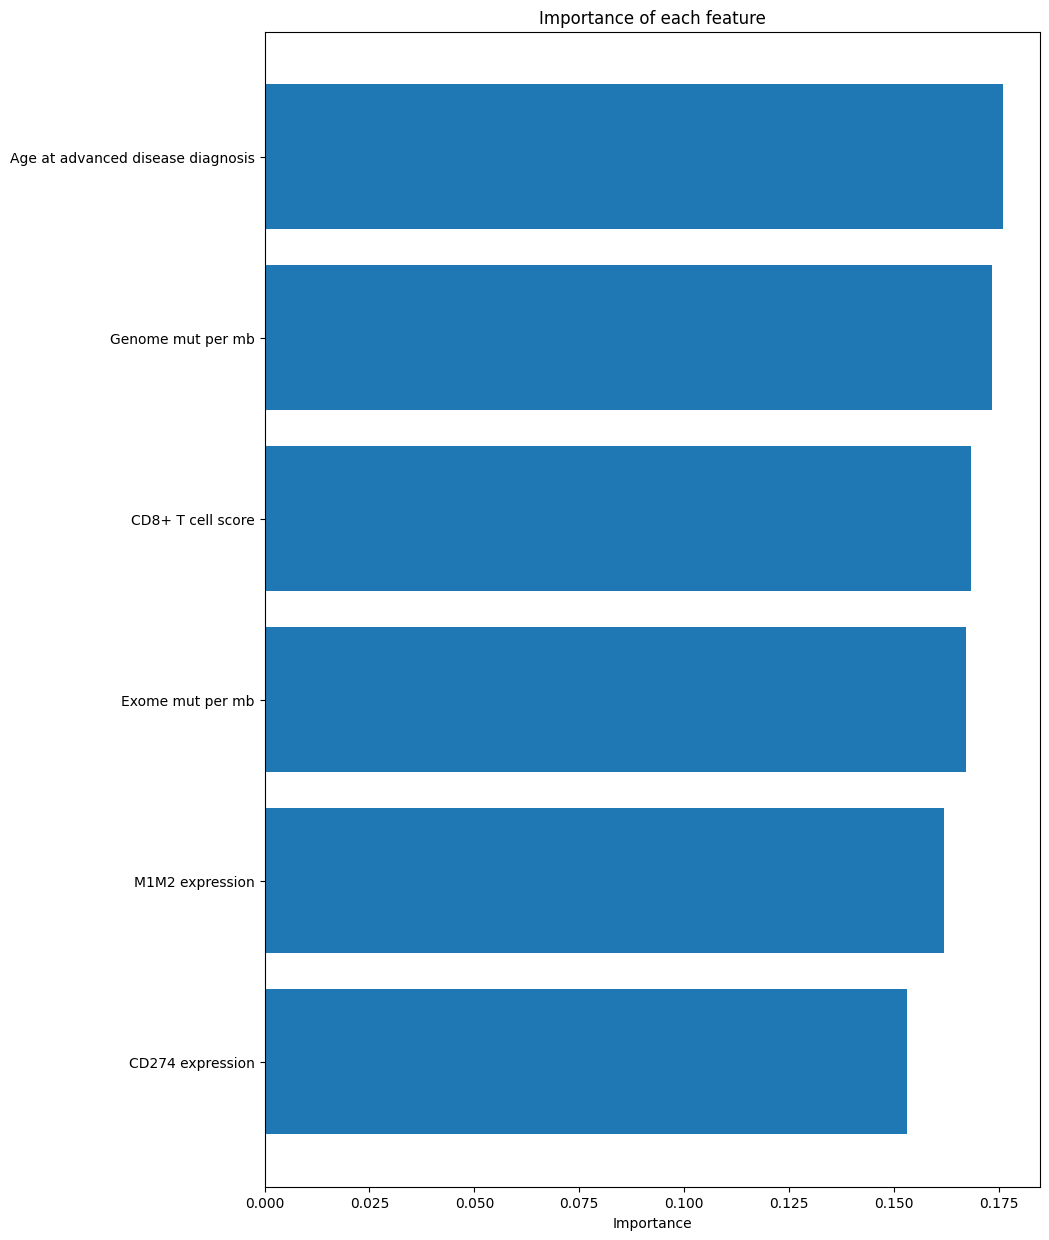

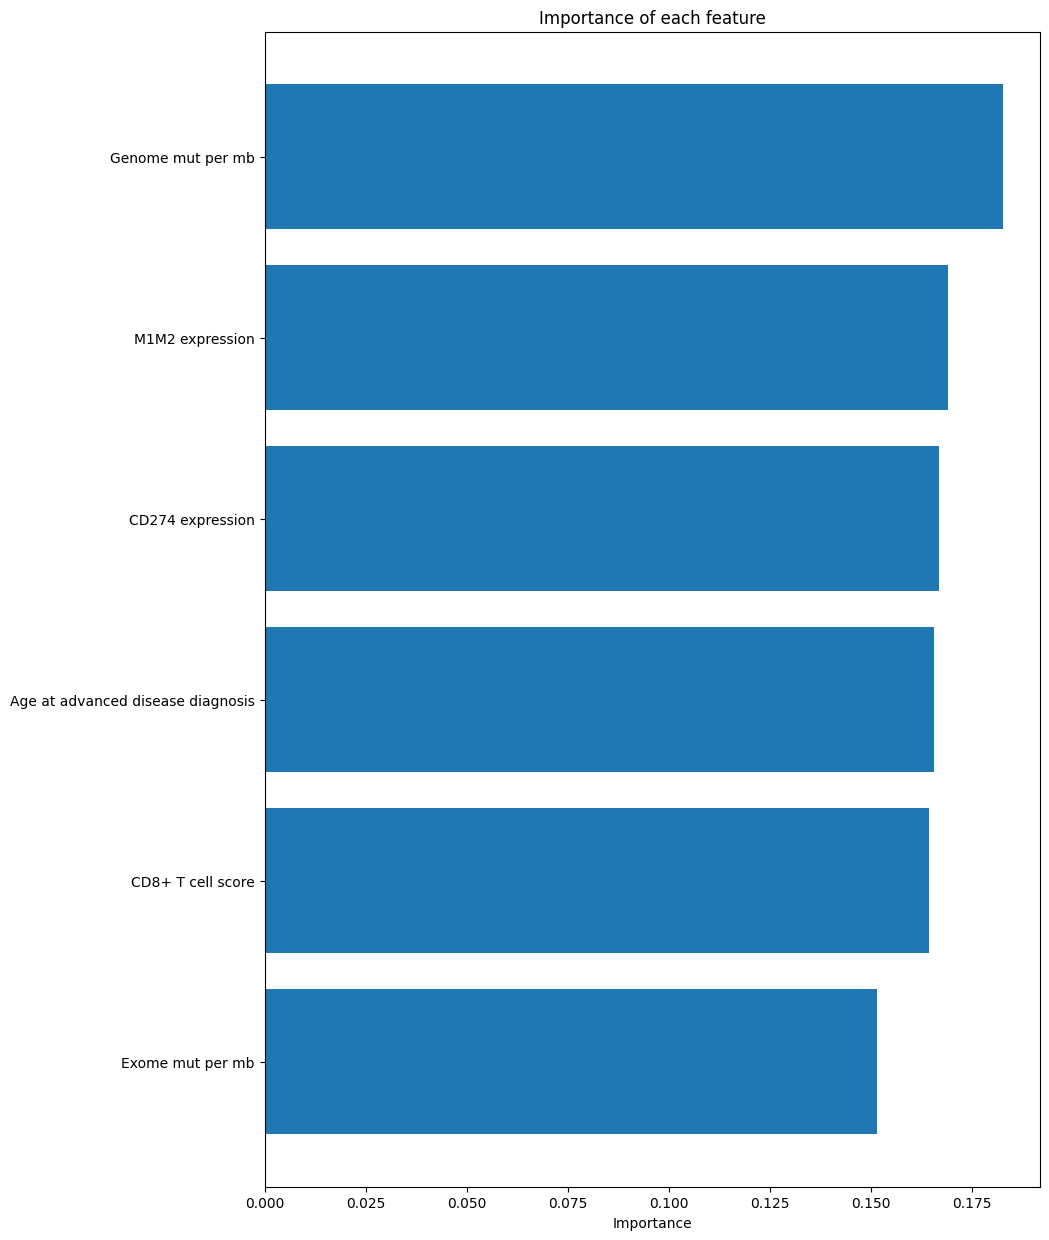

In [4]:
features_name_no_sigmut = ["Age at advanced disease diagnosis",
                           "CD8+ T cell score",
                           "Genome mut per mb",
                           "Exome mut per mb",
                           "CD274 expression",
                           "M1M2 expression"]

# Compute feature importance
# TTP :
features_name_no_sigmut_ttp = featureSelection.feature_importance(df.loc[:, features_name_no_sigmut], y_cox_ttp, True)
features_name_no_sigmut_os = featureSelection.feature_importance(df.loc[:, features_name_no_sigmut], y_cox_os, True)

# Select the most n_features important features
if n_features < len(features_name_no_sigmut):
    features_name_no_sigmut_ttp = features_name_no_sigmut_ttp[:n_features]
    features_name_no_sigmut_os = features_name_no_sigmut_os[:n_features]

# Extract features
X_no_sigmut_ttp = df.loc[:, features_name_no_sigmut_ttp].to_numpy()
X_no_sigmut_os = df.loc[:, features_name_no_sigmut_os].to_numpy()

#### Make the leave one out CV

In [5]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_no_sigmut_ttp = CoxTrainTestManager()
risk_scores_no_sigmut_ttp, risk_classes_no_sigmut_ttp = manager_no_sigmut_ttp.leave_one_out_cv(X_no_sigmut_ttp,
                                                                                               y_cox_ttp)
# OS :
manager_no_sigmut_os = CoxTrainTestManager()
risk_scores_no_sigmut_os, risk_classes_no_sigmut_os = manager_no_sigmut_os.leave_one_out_cv(X_no_sigmut_os,
                                                                                            y_cox_os)

### 2. Only mutational signatures

#### Feature selection

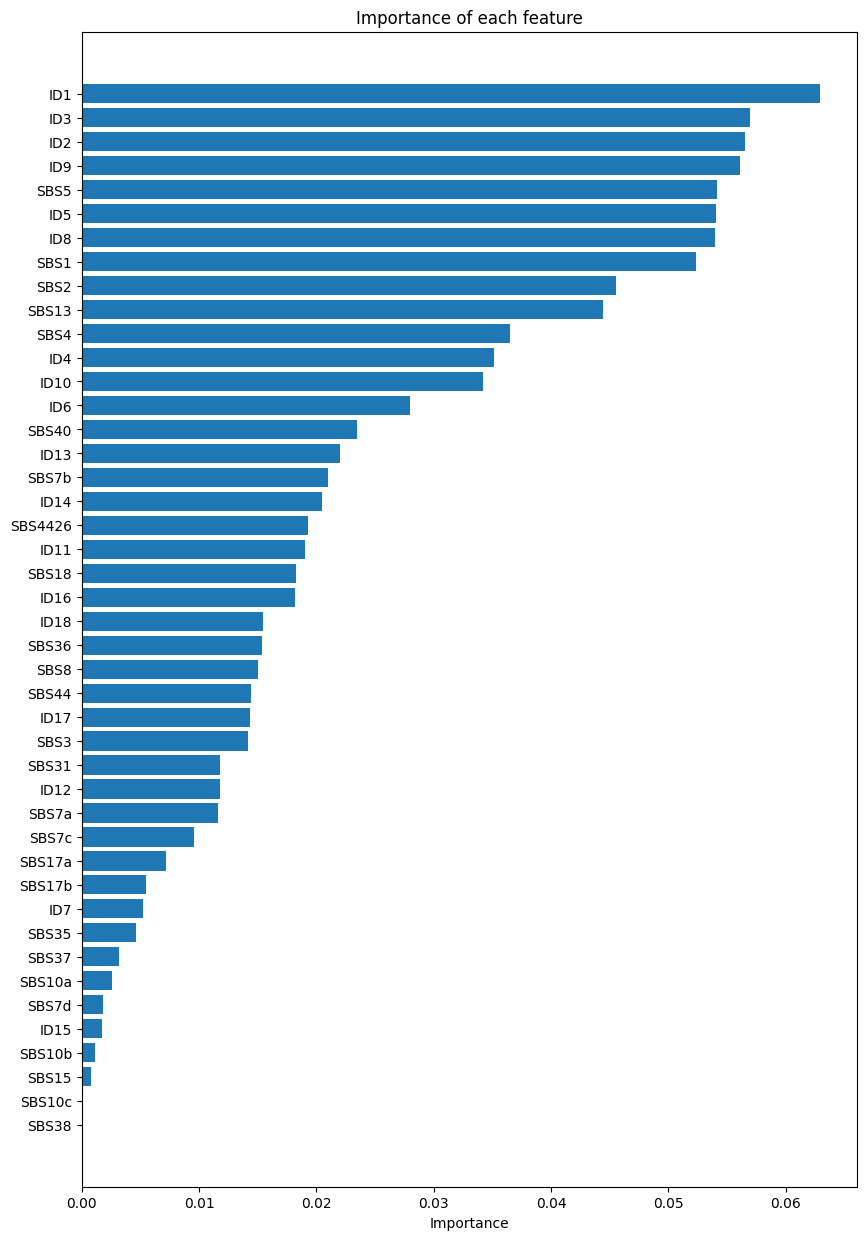

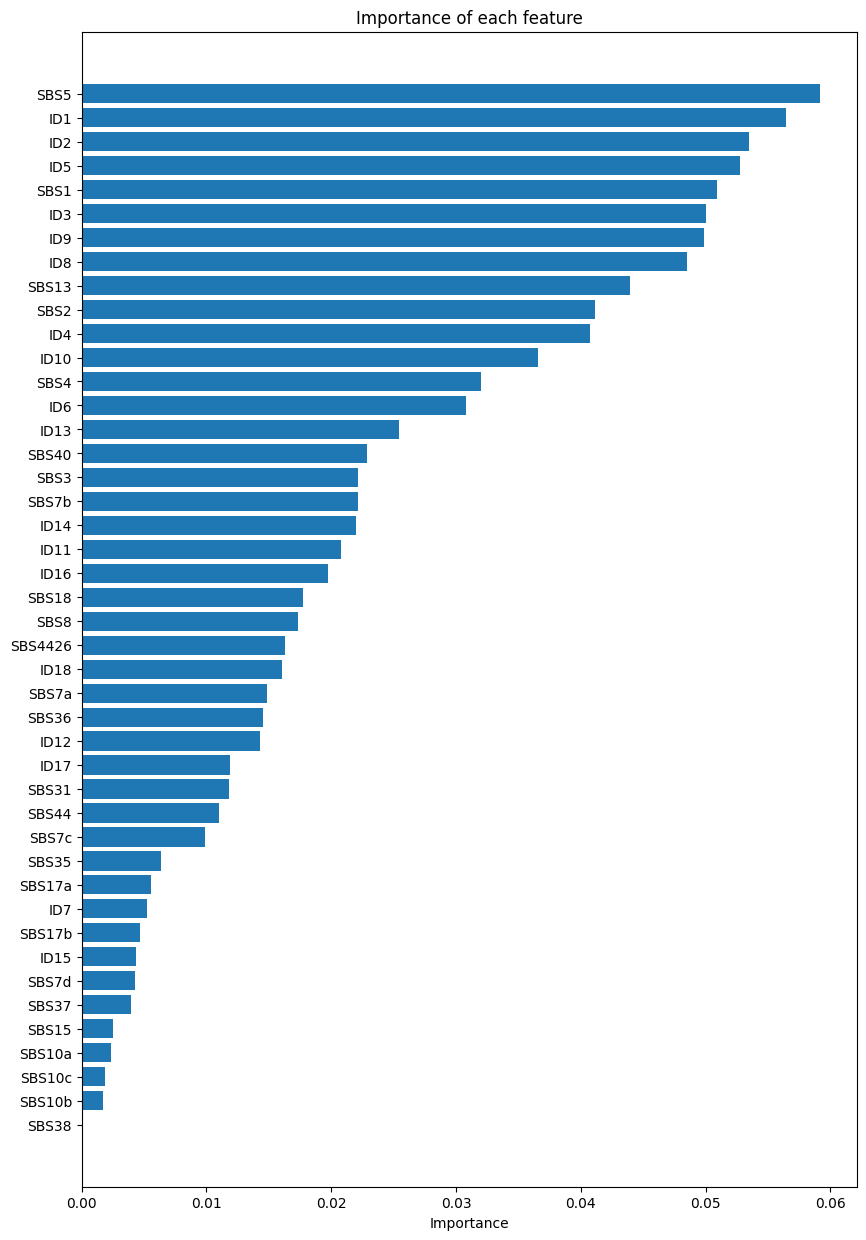

In [6]:
features_name_only_sigmut = ["SBS1",
                             "SBS2",
                             "SBS3",
                             "SBS4",
                             "SBS5",
                             "SBS7a",
                             "SBS7b",
                             "SBS7c",
                             "SBS7d",
                             "SBS8",
                             "SBS10a",
                             "SBS10b",
                             "SBS10c",
                             "SBS13",
                             "SBS15",
                             "SBS17a",
                             "SBS17b",
                             "SBS18",
                             "SBS31",
                             "SBS35",
                             "SBS36",
                             "SBS37",
                             "SBS38",
                             "SBS40",
                             "SBS44",
                             "SBS4426",
                             "ID1",
                             "ID2",
                             "ID3",
                             "ID4",
                             "ID5",
                             "ID6",
                             "ID7",
                             "ID8",
                             "ID9",
                             "ID10",
                             "ID11",
                             "ID12",
                             "ID13",
                             "ID14",
                             "ID15",
                             "ID16",
                             "ID17",
                             "ID18"]

# Compute feature importance
# TTP :
features_name_only_sigmut_ttp = featureSelection.feature_importance(df.loc[:, features_name_only_sigmut], y_cox_ttp, True)
features_name_only_sigmut_os = featureSelection.feature_importance(df.loc[:, features_name_only_sigmut], y_cox_os, True)

# Select the most n_features important features
if n_features < len(features_name_only_sigmut):
    features_name_only_sigmut_ttp = features_name_only_sigmut_ttp[:n_features]
    features_name_only_sigmut_os = features_name_only_sigmut_os[:n_features]

# Extract features
X_only_sigmut_ttp = df.loc[:, features_name_only_sigmut_ttp].to_numpy()
X_only_sigmut_os = df.loc[:, features_name_only_sigmut_os].to_numpy()

#### Make the leave one out CV

In [7]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_only_sigmut_ttp = CoxTrainTestManager()
risk_scores_only_sigmut_ttp, risk_classes_only_sigmut_ttp = manager_only_sigmut_ttp.leave_one_out_cv(X_only_sigmut_ttp, 
                                                                                                     y_cox_ttp)
# OS :
manager_only_sigmut_os = CoxTrainTestManager()
risk_scores_only_sigmut_os, risk_classes_only_sigmut_os = manager_only_sigmut_os.leave_one_out_cv(X_only_sigmut_os,
                                                                                                  y_cox_os)

### 3. Initial biomarkers + mutational signatures

#### Feature selection

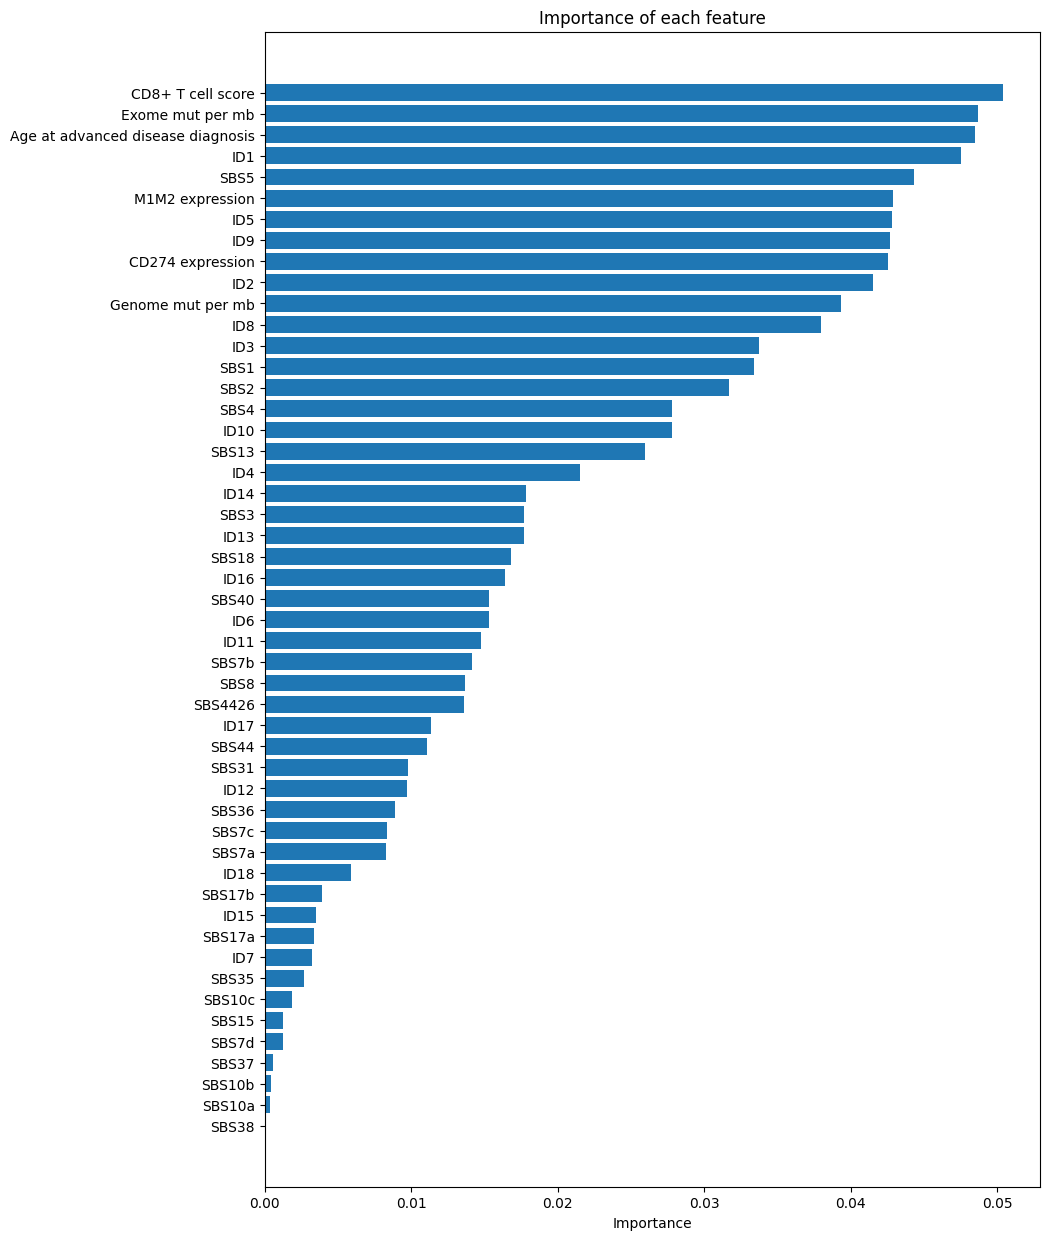

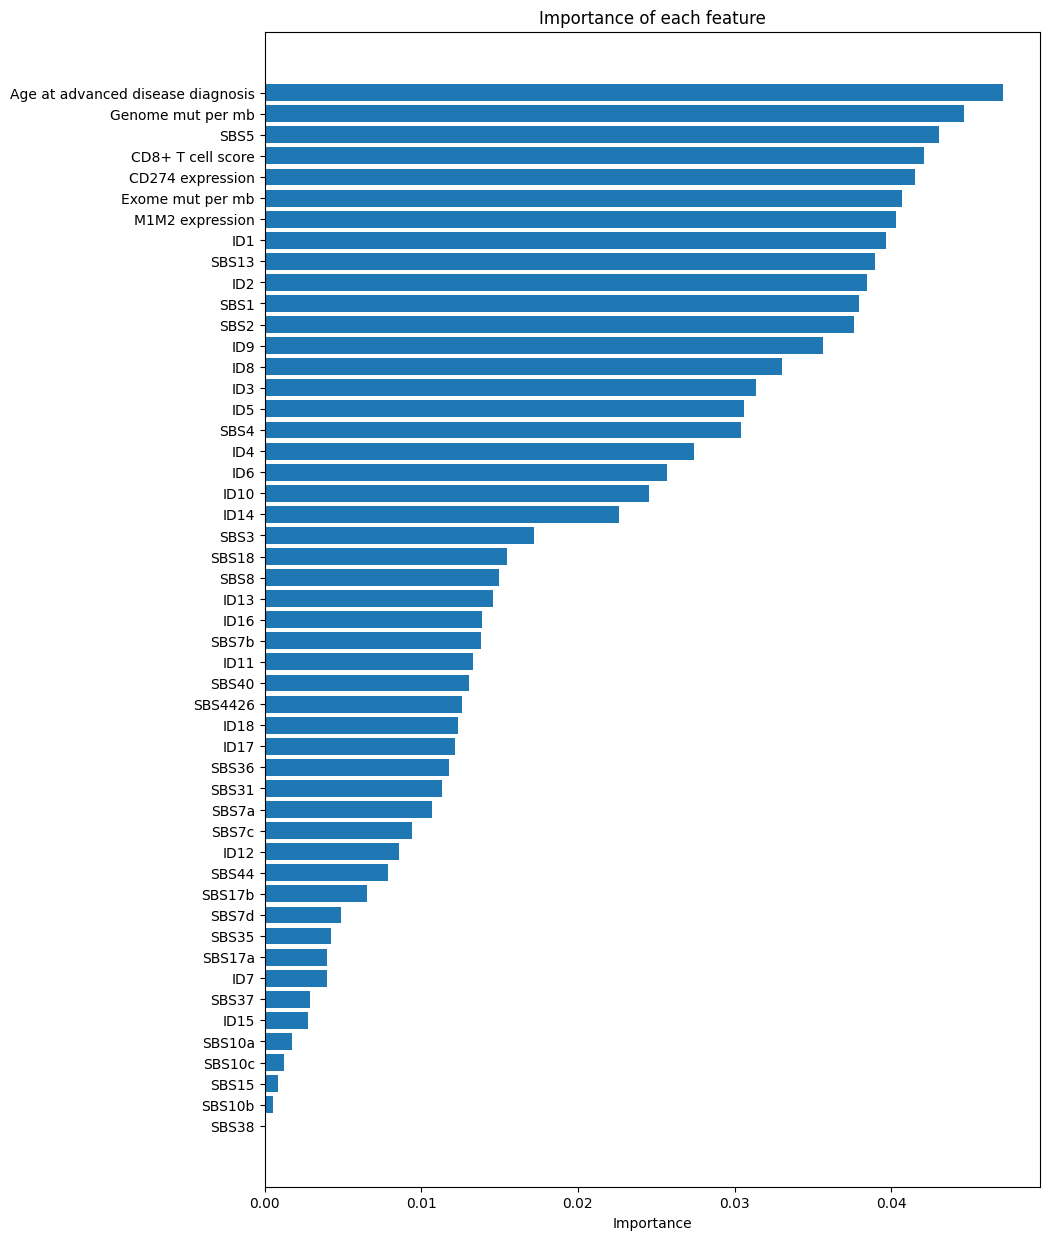

In [8]:
features_name_comb = ["Age at advanced disease diagnosis",
                      "CD8+ T cell score",
                      "Genome mut per mb",
                      "Exome mut per mb",
                      "CD274 expression",
                      "M1M2 expression",
                      "SBS1",
                      "SBS2",
                      "SBS3",
                      "SBS4",
                      "SBS5",
                      "SBS7a",
                      "SBS7b",
                      "SBS7c",
                      "SBS7d",
                      "SBS8",
                      "SBS10a",
                      "SBS10b",
                      "SBS10c",
                      "SBS13",
                      "SBS15",
                      "SBS17a",
                      "SBS17b",
                      "SBS18",
                      "SBS31",
                      "SBS35",
                      "SBS36",
                      "SBS37",
                      "SBS38",
                      "SBS40",
                      "SBS44",
                      "SBS4426",
                      "ID1",
                      "ID2",
                      "ID3",
                      "ID4",
                      "ID5",
                      "ID6",
                      "ID7",
                      "ID8",
                      "ID9",
                      "ID10",
                      "ID11",
                      "ID12",
                      "ID13",
                      "ID14",
                      "ID15",
                      "ID16",
                      "ID17",
                      "ID18"]

# Compute feature importance
# TTP :
features_name_comb_ttp = featureSelection.feature_importance(df.loc[:, features_name_comb], y_cox_ttp, True)
features_name_comb_os = featureSelection.feature_importance(df.loc[:, features_name_comb], y_cox_os, True)

# Select the most n_features important features
if n_features < len(features_name_comb):
    features_name_comb_ttp = features_name_comb_ttp[:n_features]
    features_name_comb_os = features_name_comb_os[:n_features]

# Extract features
X_comb_ttp = df.loc[:, features_name_comb_ttp].to_numpy()
X_comb_os = df.loc[:, features_name_comb_os].to_numpy()

#### Make the leave one out CV

In [9]:
# Instanciate train-test manager and make the leave one out CV
# TTP :
manager_comb_ttp = CoxTrainTestManager()
risk_scores_comb_ttp, risk_classes_comb_ttp = manager_comb_ttp.leave_one_out_cv(X_comb_ttp, y_cox_ttp)
# OS :
manager_comb_os = CoxTrainTestManager()
risk_scores_comb_os, risk_classes_comb_os = manager_comb_os.leave_one_out_cv(X_comb_os, y_cox_os)

### 4. Evaluate performances

In [10]:
status_ttp, time_ttp = df['Progression_1'].to_numpy().astype(bool), df['Time to progression (days)'].to_numpy()
status_os, time_os = df['Alive_0'].to_numpy().astype(bool), df['Overall survival (days)'].to_numpy()

#### SHAP values

In [11]:
# No sigmut
# TTP :
explainer_no_sigmut_ttp = shap.Explainer(manager_no_sigmut_ttp.model.model.predict, X_no_sigmut_ttp)
shap_values_no_sigmut_ttp = explainer_no_sigmut_ttp(X_no_sigmut_ttp)
# OS :
explainer_no_sigmut_os = shap.Explainer(manager_no_sigmut_os.model.model.predict, X_no_sigmut_os)
shap_values_no_sigmut_os = explainer_no_sigmut_os(X_no_sigmut_os)

# Only sigmut
# TTP :
explainer_only_sigmut_ttp = shap.Explainer(manager_only_sigmut_ttp.model.model.predict, X_only_sigmut_ttp)
shap_values_only_sigmut_ttp = explainer_only_sigmut_ttp(X_only_sigmut_ttp)
# OS :
explainer_only_sigmut_os = shap.Explainer(manager_only_sigmut_os.model.model.predict, X_only_sigmut_os)
shap_values_only_sigmut_os = explainer_only_sigmut_os(X_only_sigmut_os)

# Initial biomarkers + sigmut
# TTP :
explainer_comb_ttp = shap.Explainer(manager_comb_ttp.model.model.predict, X_comb_ttp)
shap_values_comb_ttp = explainer_comb_ttp(X_comb_ttp)
# OS :
explainer_comb_os = shap.Explainer(manager_comb_os.model.model.predict, X_comb_os)
shap_values_comb_os = explainer_comb_os(X_comb_os)

#### C-index

In [12]:
# No sigmut
c_index_no_sigmut_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_no_sigmut_ttp)
c_index_no_sigmut_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_no_sigmut_os)

# Only sigmut
c_index_only_sigmut_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_only_sigmut_ttp)
c_index_only_sigmut_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_only_sigmut_os)

# Initial biomarkers + sigmut
c_index_comb_ttp = SurvivalMetrics.get_c_index(status_ttp, time_ttp, risk_scores_comb_ttp)
c_index_comb_os = SurvivalMetrics.get_c_index(status_os, time_os, risk_scores_comb_os)

#### Log rank test p value

In [13]:
# No sigmut
p_value_no_sigmut_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                                  time_ttp,
                                                                  risk_classes_no_sigmut_ttp)
p_value_no_sigmut_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                                 time_os,
                                                                 risk_classes_no_sigmut_os)

# Only sigmut
p_value_only_sigmut_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                                  time_ttp,
                                                                  risk_classes_only_sigmut_ttp)
p_value_only_sigmut_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                                 time_os,
                                                                 risk_classes_only_sigmut_os)

# Initial biomarkers + sigmut
p_value_comb_ttp = SurvivalMetrics.get_p_value_log_rank_test(status_ttp.astype(int),
                                                                  time_ttp,
                                                                  risk_classes_comb_ttp)
p_value_comb_os = SurvivalMetrics.get_p_value_log_rank_test(status_os.astype(int),
                                                                 time_os,
                                                                 risk_classes_comb_os)

#### Kaplan Meier curves

In [14]:
# No sigmut
# TTP, low risk :
status_low_risk_no_sigmut_ttp = status_ttp[np.where(risk_classes_no_sigmut_ttp == 0)]
time_low_risk_no_sigmut_ttp = time_ttp[np.where(risk_classes_no_sigmut_ttp == 0)]
time_axis_low_risk_no_sigmut_ttp, prob_axis_low_risk_no_sigmut_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_no_sigmut_ttp, time_low_risk_no_sigmut_ttp)
# TTP, high risk :
status_high_risk_no_sigmut_ttp = status_ttp[np.where(risk_classes_no_sigmut_ttp == 1)]
time_high_risk_no_sigmut_ttp = time_ttp[np.where(risk_classes_no_sigmut_ttp == 1)]
time_axis_high_risk_no_sigmut_ttp, prob_axis_high_risk_no_sigmut_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_no_sigmut_ttp, time_high_risk_no_sigmut_ttp)
# OS, low risk :
status_low_risk_no_sigmut_os = status_os[np.where(risk_classes_no_sigmut_os == 0)]
time_low_risk_no_sigmut_os = time_os[np.where(risk_classes_no_sigmut_os == 0)]
time_axis_low_risk_no_sigmut_os, prob_axis_low_risk_no_sigmut_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_no_sigmut_os, time_low_risk_no_sigmut_os)
# OS, high risk :
status_high_risk_no_sigmut_os = status_os[np.where(risk_classes_no_sigmut_os == 1)]
time_high_risk_no_sigmut_os = time_os[np.where(risk_classes_no_sigmut_os == 1)]
time_axis_high_risk_no_sigmut_os, prob_axis_high_risk_no_sigmut_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_no_sigmut_os, time_high_risk_no_sigmut_os)

# Only sigmut
# TTP, low risk :
status_low_risk_only_sigmut_ttp = status_ttp[np.where(risk_classes_only_sigmut_ttp == 0)]
time_low_risk_only_sigmut_ttp = time_ttp[np.where(risk_classes_only_sigmut_ttp == 0)]
time_axis_low_risk_only_sigmut_ttp, prob_axis_low_risk_only_sigmut_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_only_sigmut_ttp, time_low_risk_only_sigmut_ttp)
# TTP, high risk :
status_high_risk_only_sigmut_ttp = status_ttp[np.where(risk_classes_only_sigmut_ttp == 1)]
time_high_risk_only_sigmut_ttp = time_ttp[np.where(risk_classes_only_sigmut_ttp == 1)]
time_axis_high_risk_only_sigmut_ttp, prob_axis_high_risk_only_sigmut_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_only_sigmut_ttp, time_high_risk_only_sigmut_ttp)
# OS, low risk :
status_low_risk_only_sigmut_os = status_os[np.where(risk_classes_only_sigmut_os == 0)]
time_low_risk_only_sigmut_os = time_os[np.where(risk_classes_only_sigmut_os == 0)]
time_axis_low_risk_only_sigmut_os, prob_axis_low_risk_only_sigmut_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_only_sigmut_os, time_low_risk_only_sigmut_os)
# OS, high risk :
status_high_risk_only_sigmut_os = status_os[np.where(risk_classes_only_sigmut_os == 1)]
time_high_risk_only_sigmut_os = time_os[np.where(risk_classes_only_sigmut_os == 1)]
time_axis_high_risk_only_sigmut_os, prob_axis_high_risk_only_sigmut_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_only_sigmut_os, time_high_risk_only_sigmut_os)

# Initial biomarkers + sigmut
# TTP, low risk :
status_low_risk_comb_ttp = status_ttp[np.where(risk_classes_comb_ttp == 0)]
time_low_risk_comb_ttp = time_ttp[np.where(risk_classes_comb_ttp == 0)]
time_axis_low_risk_comb_ttp, prob_axis_low_risk_comb_ttp = SurvivalMetrics.estimate_survival_curve(status_low_risk_comb_ttp, time_low_risk_comb_ttp)
# TTP, high risk :
status_high_risk_comb_ttp = status_ttp[np.where(risk_classes_comb_ttp == 1)]
time_high_risk_comb_ttp = time_ttp[np.where(risk_classes_comb_ttp == 1)]
time_axis_high_risk_comb_ttp, prob_axis_high_risk_comb_ttp = SurvivalMetrics.estimate_survival_curve(status_high_risk_comb_ttp, time_high_risk_comb_ttp)
# OS, low risk :
status_low_risk_comb_os = status_os[np.where(risk_classes_comb_os == 0)]
time_low_risk_comb_os = time_os[np.where(risk_classes_comb_os == 0)]
time_axis_low_risk_comb_os, prob_axis_low_risk_comb_os = SurvivalMetrics.estimate_survival_curve(status_low_risk_comb_os, time_low_risk_comb_os)
# OS, high risk :
status_high_risk_comb_os = status_os[np.where(risk_classes_comb_os == 1)]
time_high_risk_comb_os = time_os[np.where(risk_classes_comb_os == 1)]
time_axis_high_risk_comb_os, prob_axis_high_risk_comb_os = SurvivalMetrics.estimate_survival_curve(status_high_risk_comb_os, time_high_risk_comb_os)

#### Plot results

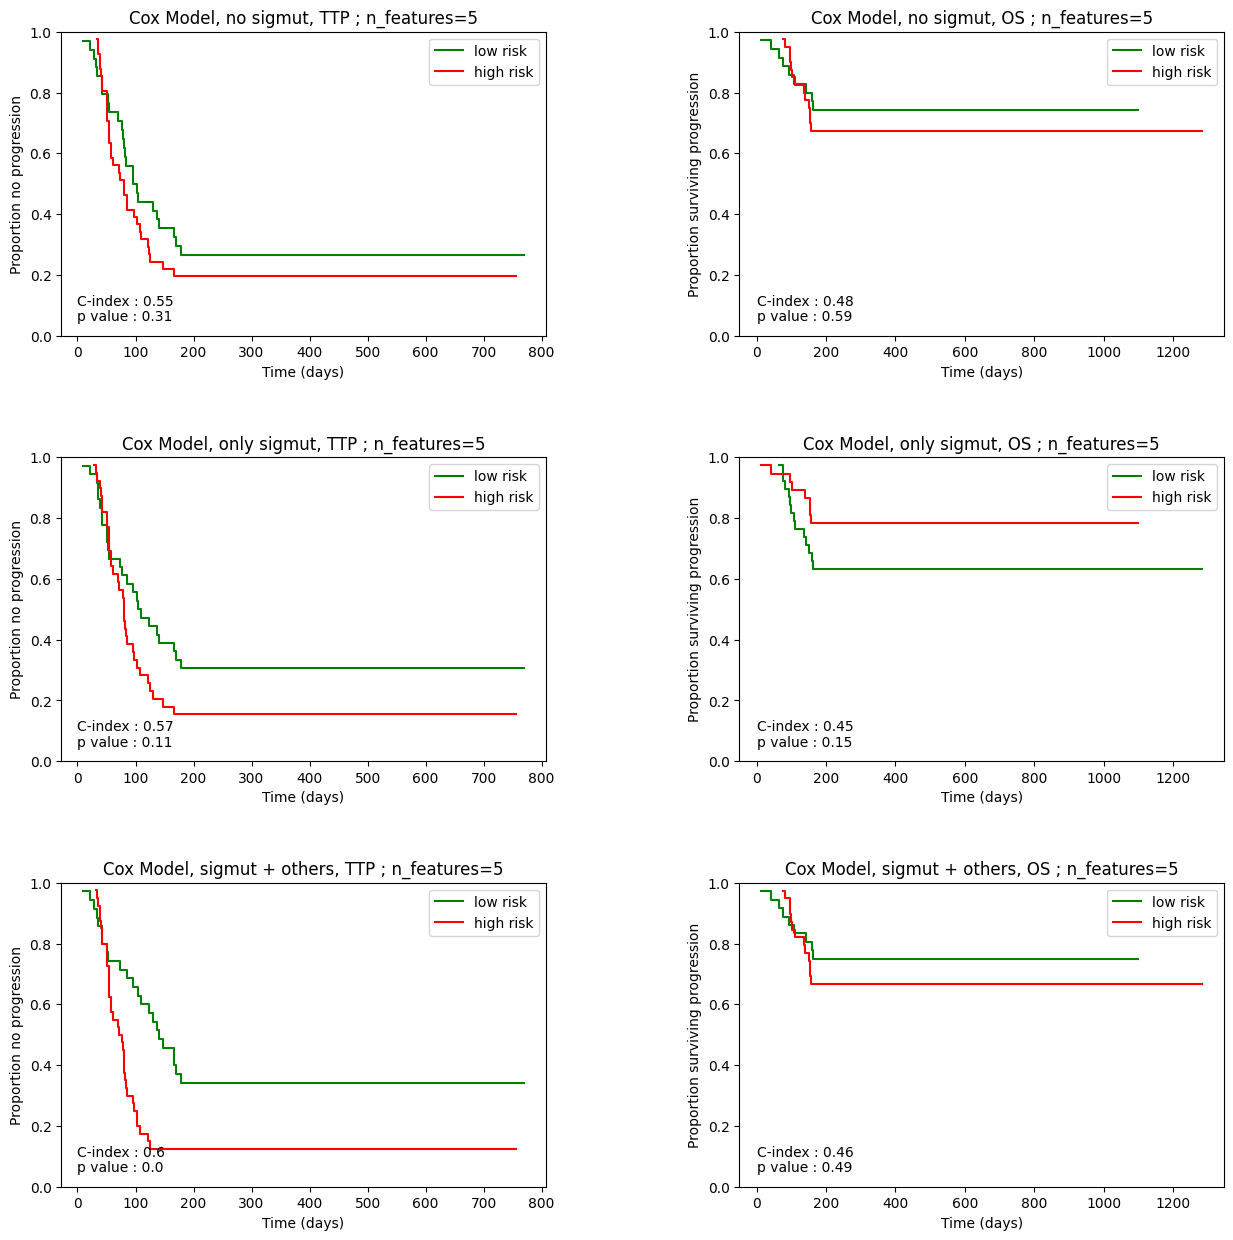

In [15]:
fig = plt.figure()

# NO SIGMUT
# TTP :
ax0 = fig.add_subplot(321)
ax0.step(time_axis_low_risk_no_sigmut_ttp, prob_axis_low_risk_no_sigmut_ttp, where='post',color='green',label='low risk')
ax0.step(time_axis_high_risk_no_sigmut_ttp, prob_axis_high_risk_no_sigmut_ttp, where='post',color='red',label='high risk')
ax0.set_xlabel('Time (days)')
ax0.set_ylabel('Proportion no progression')
ax0.set_title(f'Cox Model, no sigmut, TTP ; n_features={n_features}')
ax0.text(0,0.1,f'C-index : {c_index_no_sigmut_ttp}')
ax0.text(0,0.05,f'p value : {p_value_no_sigmut_ttp}')
ax0.set_ylim(0,1)
ax0.legend()

# OS :
ax1 = fig.add_subplot(322)
ax1.step(time_axis_low_risk_no_sigmut_os, prob_axis_low_risk_no_sigmut_os, where='post',color='green',label='low risk')
ax1.step(time_axis_high_risk_no_sigmut_os, prob_axis_high_risk_no_sigmut_os, where='post',color='red',label='high risk')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Proportion surviving progression')
ax1.set_title(f'Cox Model, no sigmut, OS ; n_features={n_features}')
ax1.text(0,0.1,f'C-index : {c_index_no_sigmut_os}')
ax1.text(0,0.05,f'p value : {p_value_no_sigmut_os}')
ax1.set_ylim(0,1)
ax1.legend()

# ONLY SIGMUT
# TTP :
ax3 = fig.add_subplot(323)
ax3.step(time_axis_low_risk_only_sigmut_ttp, prob_axis_low_risk_only_sigmut_ttp, where='post',color='green',label='low risk')
ax3.step(time_axis_high_risk_only_sigmut_ttp, prob_axis_high_risk_only_sigmut_ttp, where='post',color='red',label='high risk')
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Proportion no progression')
ax3.set_title(f'Cox Model, only sigmut, TTP ; n_features={n_features}')
ax3.text(0,0.1,f'C-index : {c_index_only_sigmut_ttp}')
ax3.text(0,0.05,f'p value : {p_value_only_sigmut_ttp}')
ax3.set_ylim(0,1)
ax3.legend()

# OS :
ax4 = fig.add_subplot(324)
ax4.step(time_axis_low_risk_only_sigmut_os, prob_axis_low_risk_only_sigmut_os, where='post',color='green',label='low risk')
ax4.step(time_axis_high_risk_only_sigmut_os, prob_axis_high_risk_only_sigmut_os, where='post',color='red',label='high risk')
ax4.set_xlabel('Time (days)')
ax4.set_ylabel('Proportion surviving progression')
ax4.set_title(f'Cox Model, only sigmut, OS ; n_features={n_features}')
ax4.text(0,0.1,f'C-index : {c_index_only_sigmut_os}')
ax4.text(0,0.05,f'p value : {p_value_only_sigmut_os}')
ax4.set_ylim(0,1)
ax4.legend()

# SIGMUT + OTHER BIOMARKERS
# TTP :
ax6 = fig.add_subplot(325)
ax6.step(time_axis_low_risk_comb_ttp, prob_axis_low_risk_comb_ttp, where='post',color='green',label='low risk')
ax6.step(time_axis_high_risk_comb_ttp, prob_axis_high_risk_comb_ttp, where='post',color='red',label='high risk')
ax6.set_xlabel('Time (days)')
ax6.set_ylabel('Proportion no progression')
ax6.set_title(f'Cox Model, sigmut + others, TTP ; n_features={n_features}')
ax6.text(0,0.1,f'C-index : {c_index_comb_ttp}')
ax6.text(0,0.05,f'p value : {p_value_comb_ttp}')
ax6.set_ylim(0,1)
ax6.legend()

# OS :
ax7 = fig.add_subplot(326)
ax7.step(time_axis_low_risk_comb_os, prob_axis_low_risk_comb_os, where='post',color='green',label='low risk')
ax7.step(time_axis_high_risk_comb_os, prob_axis_high_risk_comb_os, where='post',color='red',label='high risk')
ax7.set_xlabel('Time (days)')
ax7.set_ylabel('Proportion surviving progression')
ax7.set_title(f'Cox Model, sigmut + others, OS ; n_features={n_features}')
ax7.text(0,0.1,f'C-index : {c_index_comb_os}')
ax7.text(0,0.05,f'p value : {p_value_comb_os}')
ax7.set_ylim(0,1)
ax7.legend()

plt.gcf().set_size_inches(15,15)
plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
The figure layout has changed to tight


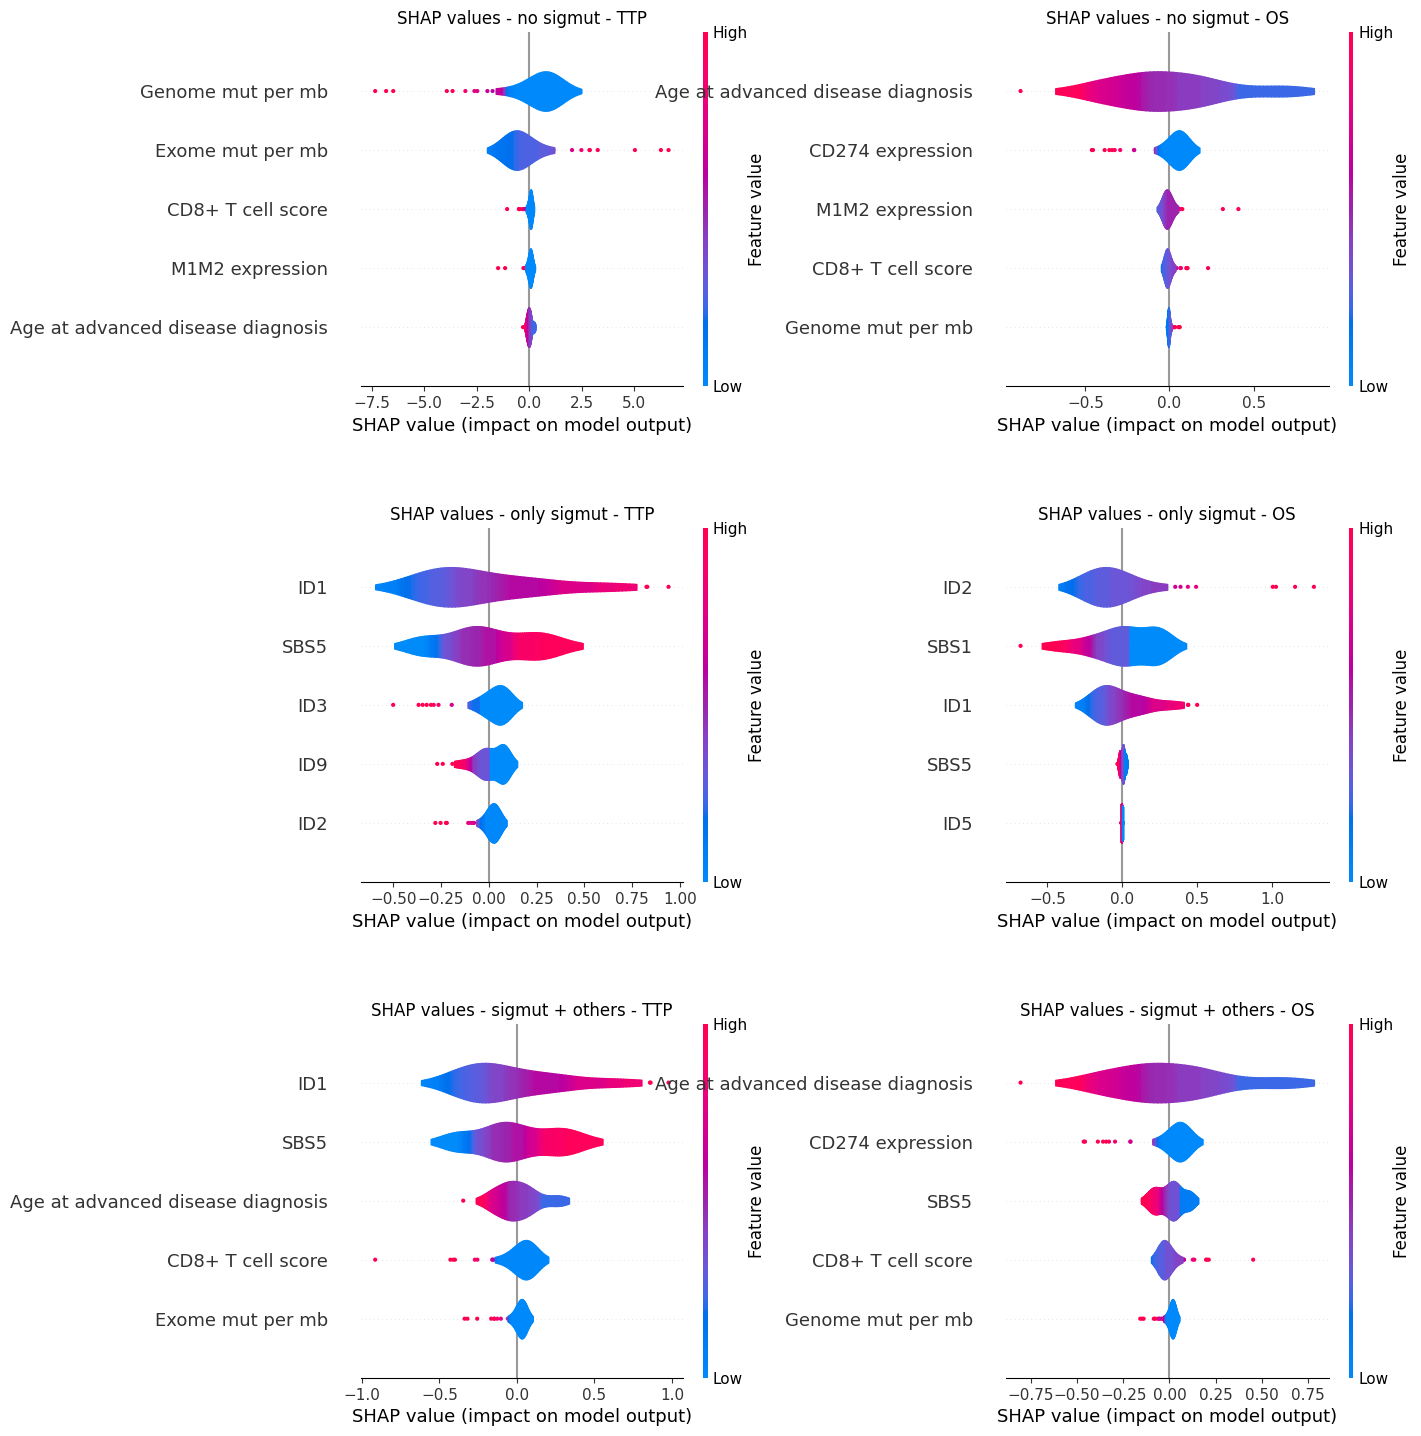

In [16]:
fig = plt.figure()

# no sigmut
ax2 = fig.add_subplot(321)
shap.summary_plot(shap_values_no_sigmut_ttp, plot_type='violin', feature_names=features_name_no_sigmut_ttp, show=False)
ax2.set_title("SHAP values - no sigmut - TTP")
ax22 = fig.add_subplot(322)
shap.summary_plot(shap_values_no_sigmut_os, plot_type='violin', feature_names=features_name_no_sigmut_os, show=False)
ax22.set_title("SHAP values - no sigmut - OS")

# only sigmut
ax5 = fig.add_subplot(323)
shap.summary_plot(shap_values_only_sigmut_ttp, plot_type='violin', feature_names=features_name_only_sigmut_ttp, show=False)
ax5.set_title("SHAP values - only sigmut - TTP")
ax52 = fig.add_subplot(324)
shap.summary_plot(shap_values_only_sigmut_os, plot_type='violin', feature_names=features_name_only_sigmut_os, show=False)
ax52.set_title("SHAP values - only sigmut - OS")

# initial biomarkers + sigmut
ax8 = fig.add_subplot(325)
shap.summary_plot(shap_values_comb_ttp, plot_type='violin', feature_names=features_name_comb_ttp, show=False)
ax8.set_title("SHAP values - sigmut + others - TTP")
ax82 = fig.add_subplot(326)
shap.summary_plot(shap_values_comb_os, plot_type='violin', feature_names=features_name_comb_os, show=False)
ax82.set_title("SHAP values - sigmut + others - OS")

plt.gcf().set_size_inches(20,15)
plt.subplots_adjust(hspace=0.4,wspace=0.6)
plt.show()